# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC 

from qiskit import QuantumCircuit, Aer, execute, IBMQ
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel

# Pre-processing
## Load Data

In [2]:
# read in data
df_cat = pd.read_csv('cleaned_QC_data.csv')

# group by circuit
df_gb = df_cat.groupby('Circuit')

# intitiate list dfs for each circuit
list_dfs = []

# do for all 9 circuits
for i in range(9):
    # get group for the current circuit and reset the index
    df_sub = df_gb.get_group(i+1)[['p00','p01','p10','p11']].reset_index(drop=True)
    
    # create new column names which include the circuit number
    col_names = {'p00':'p00_'+str(i+1),'p01':'p01_'+str(i+1),'p10':'p10_'+str(i+1),'p11':'p11_'+str(i+1)}
    df_sub.rename(columns=col_names, inplace=True)
    
    # add df to list
    list_dfs.append(df_sub)

# concatenate groups from list
df = pd.concat(list_dfs, axis=1)

# append target column
df['QC Name'] = df_gb.get_group(1)['QC Name'].reset_index(drop=True)

# shuffle
df = df.sample(frac=1).reset_index(drop=True)

# show
df

,p00_1,p01_1,p10_1,p11_1,p00_2,p01_2,p10_2,p11_2,p00_3,p01_3,...,p11_7,p00_8,p01_8,p10_8,p11_8,p00_9,p01_9,p10_9,p11_9,QC Name
0,0.513,0.467,0.008,0.012,0.233,0.278,0.252,0.237,0.094,0.417,...,0.123,0.425,0.192,0.236,0.147,0.380,0.227,0.228,0.165,casablanca
1,0.490,0.503,0.004,0.003,0.327,0.288,0.177,0.208,0.188,0.433,...,0.192,0.341,0.227,0.226,0.206,0.316,0.274,0.201,0.209,quito
2,0.515,0.471,0.005,0.009,0.322,0.291,0.139,0.248,0.189,0.442,...,0.183,0.338,0.220,0.229,0.213,0.319,0.242,0.254,0.185,quito
3,0.507,0.488,0.004,0.001,0.281,0.257,0.231,0.231,0.067,0.476,...,0.177,0.418,0.191,0.248,0.143,0.365,0.252,0.236,0.147,athens
4,0.509,0.480,0.007,0.004,0.329,0.277,0.162,0.232,0.163,0.464,...,0.209,0.338,0.200,0.238,0.224,0.349,0.253,0.210,0.188,quito
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,0.839,0.127,0.030,0.004,0.263,0.269,0.268,0.200,0.153,0.410,...,0.174,0.310,0.267,0.242,0.181,0.285,0.318,0.183,0.214,yorktown
13996,0.528,0.465,0.005,0.002,0.343,0.300,0.137,0.220,0.166,0.439,...,0.186,0.300,0.230,0.243,0.227,0.329,0.253,0.233,0.185,quito
13997,0.513,0.484,0.001,0.002,0.270,0.244,0.275,0.211,0.081,0.451,...,0.149,0.444,0.189,0.208,0.159,0.407,0.242,0.218,0.133,athens
13998,0.514,0.469,0.011,0.006,0.278,0.235,0.259,0.228,0.115,0.417,...,0.129,0.435,0.190,0.208,0.167,0.378,0.273,0.192,0.157,casablanca


## Batch
There are too many rows to run on a quantum simulator in a reasonable amount of time so a small random batch is selected.

In [3]:
# set sample size 
n = 200

# sample
df = df.sample(n).reset_index(drop=True)

## Train-Test Split

In [4]:
# split data (test size is 25%, use random seed for reproducability)
df_tr,df_va = train_test_split(df, test_size=0.25, random_state=0)

X_tr = df_tr.drop(['QC Name'], axis=1)
X_va = df_va.drop(['QC Name'], axis=1)

Y_tr = df_tr['QC Name'].to_numpy()
Y_va = df_va['QC Name'].to_numpy()

# show shapes of train and test inputs and target
print ('training set ==',X_tr.shape,Y_tr.shape,', validation set ==', X_va.shape,Y_va.shape)

training set == (150, 36) (150,) , validation set == (50, 36) (50,)


## Principle Component Analysis (PCA)
PCA is used for dimensionality reduction from 36 features down to 5 so that the program can be run on 5-qubit quantum hardware.

In [5]:
# instantiate PCA for 5 components
pca = PCA(5)

# fit PCA on training data
pca.fit(X_tr)

# transform training and testing data
X_tr_pca = pca.transform(X_tr)
X_va_pca = pca.transform(X_va)

# show shapes of train and test inputs and target
print ('training set ==',X_tr_pca.shape,Y_tr.shape,', validation set ==', X_va_pca.shape,Y_va.shape)

training set == (150, 5) (150,) , validation set == (50, 5) (50,)


# Quantum Kernel Estimation

## Quantum Instance Configuration
The backend is set to the QASM simulator from Aer.

In [6]:
# set backend
backend = Aer.get_backend('qasm_simulator')

# set seed
SEED = 102855

# set number of shots
shots = 8092

# create quantum instance
qinst = QuantumInstance(backend, shots, SEED)

## Quantum Kernel
The quantum kernel circuit is created using the ZZ feature map. The ZZ feature map involves $Z$ rotations where the angle of rotation is determined by the input $x$.

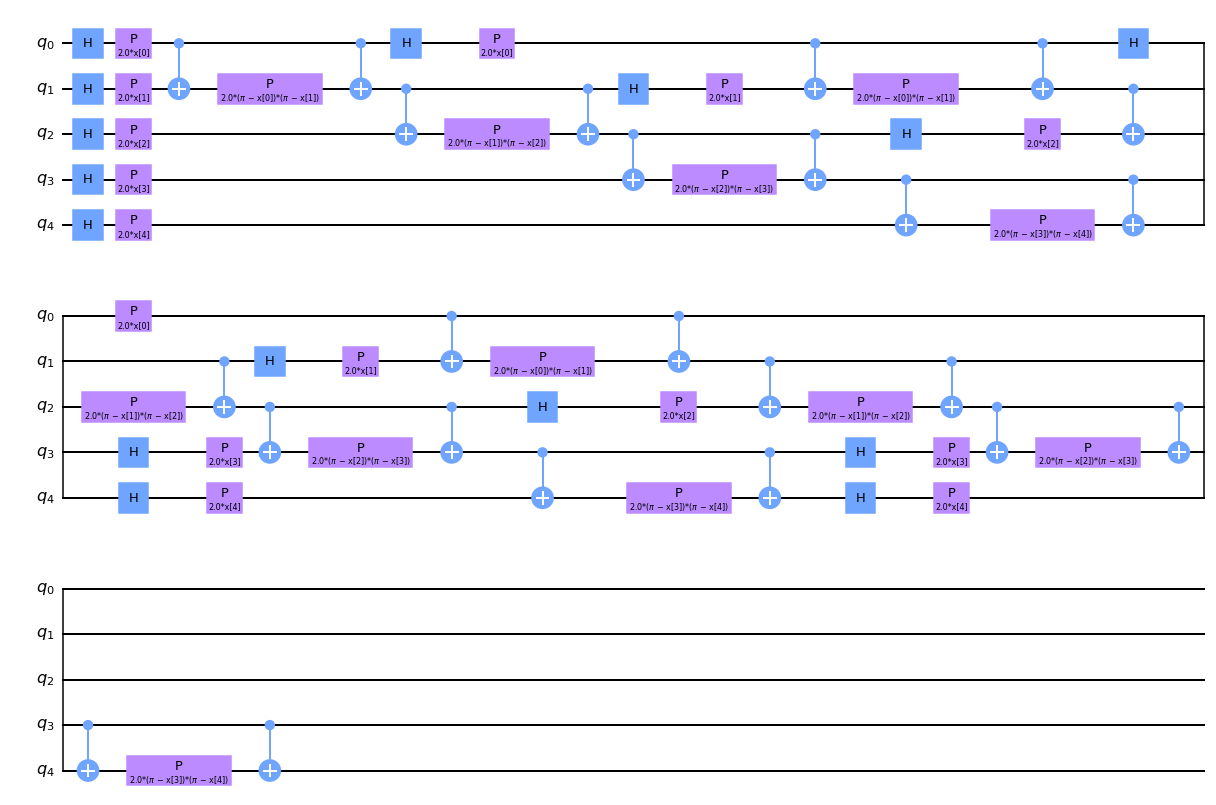

In [7]:
# encode data via ZZ feature map
map_z = ZZFeatureMap(feature_dimension=5, reps=3, entanglement='linear')

# draw ZZ Feature Map
map_z.decompose().draw('mpl')

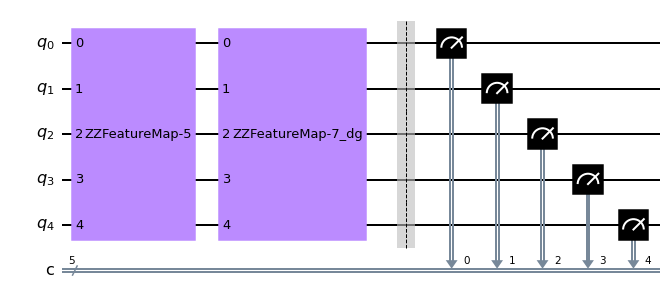

In [8]:
# create kernel circuit
z_kernel = QuantumKernel(feature_map=map_z, quantum_instance=qinst)

# draw circuit
kernel_qc = z_kernel.construct_circuit(X_tr_pca[0])
kernel_qc.draw('mpl')

The quantum kernel matrix for the training data is shown in Figure 1. The darker squares indicate when two inputs are closer together.

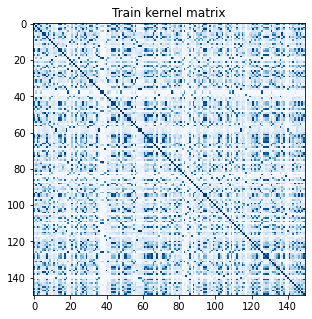

In [9]:
# find kernel matrix
with np.errstate(divide='ignore',invalid='ignore'):
    train_matrix= z_kernel.evaluate(x_vec=X_tr_pca)

# show kernel
fig, axs = plt.subplots(1, figsize=(10, 5))
axs.imshow(
    np.asmatrix(train_matrix), interpolation="nearest", origin="upper", cmap="Blues"
)
axs.set_title("Train kernel matrix")
plt.show()

*Figure 1: Quantum kernel matrix for training data*

# Quantum Support Vector Classification (SVC)
Using the quantum kernel to determine the distance between points, perform SVC.

In [10]:
# do support vector classification with quantum kernel
with np.errstate(divide='ignore', invalid='ignore'):
    q_model = SVC(kernel=z_kernel.evaluate)
    q_model.fit(X_tr_pca, Y_tr)
    q_score = q_model.score(X_va_pca, Y_va)
    
# show validation score
print("Quantum kernel validation score", q_score)

Quantum kernel validation score 0.92


# Classical Support Vector Classification (SVC)
SCV is carried out using two different classical kernels for comparison. The linear kernel is simply 
\begin{equation}
    k(x,x') = \langle x, x' \rangle
\end{equation}
and the RBF kernel is 
\begin{equation*}
    k(x,x') =e^{-\gamma \|x - x'\|^2}.
\end{equation*}

In [11]:
# do support vector classification with linear kernel
l_model = SVC(kernel='linear')
l_model.fit(X_tr_pca, Y_tr)
l_score = l_model.score(X_va_pca, Y_va)

# show validation score
print("Linear kernel validation score", l_score)

Linear kernel validation score 0.68


In [12]:
# do support vector classification with rbf kernel (default)
rbf_model = SVC(kernel='rbf')
rbf_model.fit(X_tr_pca, Y_tr)
rbf_score = rbf_model.score(X_va_pca, Y_va)

# show validation score
print("RBF kernel validation score", rbf_score)

RBF kernel validation score 0.86


In [1]:
import qiskit.tools.jupyter
%qiskit_version_table